# Stationary FFA

Flood frequency analysis (FFA) estimates the severity of streamflow events based on observed data.
Results are typically expressed in terms of *return periods* and *return levels*.
The *return period* of a flood is the expected number of years between streamflow events of equal or greater severity.
The *return level* is the magnitude of the streamflow event, measured in $\text{m}^3/\text{s}$.
This vignette demonstrates stationary FFA using the `ffaframework` package.


## Setup

In [1]:
options(repr.plot.width = 12, repr.plot.height = 10) # Set plot sizes

library(ffaframework)
csv_path <- system.file("extdata", "Application_1.csv", package = "ffaframework")
df <- read.csv(csv_path)
df <- subset(df, !is.na(max)) # Remove missing values
head(df)

Loading required package: ggplot2

Loading required package: patchwork



,year,max
,<int>,<dbl>
14,1913,1670
15,1914,3090
16,1915,2760
17,1916,2080
18,1917,2490
19,1918,1470


## Distribution Selection

In the first stage of FFA, a suitable probability distribution for the data is selected.
The `ffaframework` package includes three L-moment-based metrics for selecting a suitable distribution:

1. `select_ldistance` chooses the distribution whose theoretical L-skewness ($t_3$) and L-kurtosis ($t_4$) have the smallest Euclidean distance from the sample point.
2. `select_lkurtosis` matches theoretical L-kurtosis to the sample L-kurtosis.
3. `select_zstatistic` uses a fitted 4-parameter Kappa distribution to estimate the sampling distribution of the L-kurtosis and selects the distribution with the smallest z-statistic.

The `select_ldistance` metric will be used in this vignette.

The `plot_lmom_diagram` function displays the results of distribution selection.

[1] "GEV"


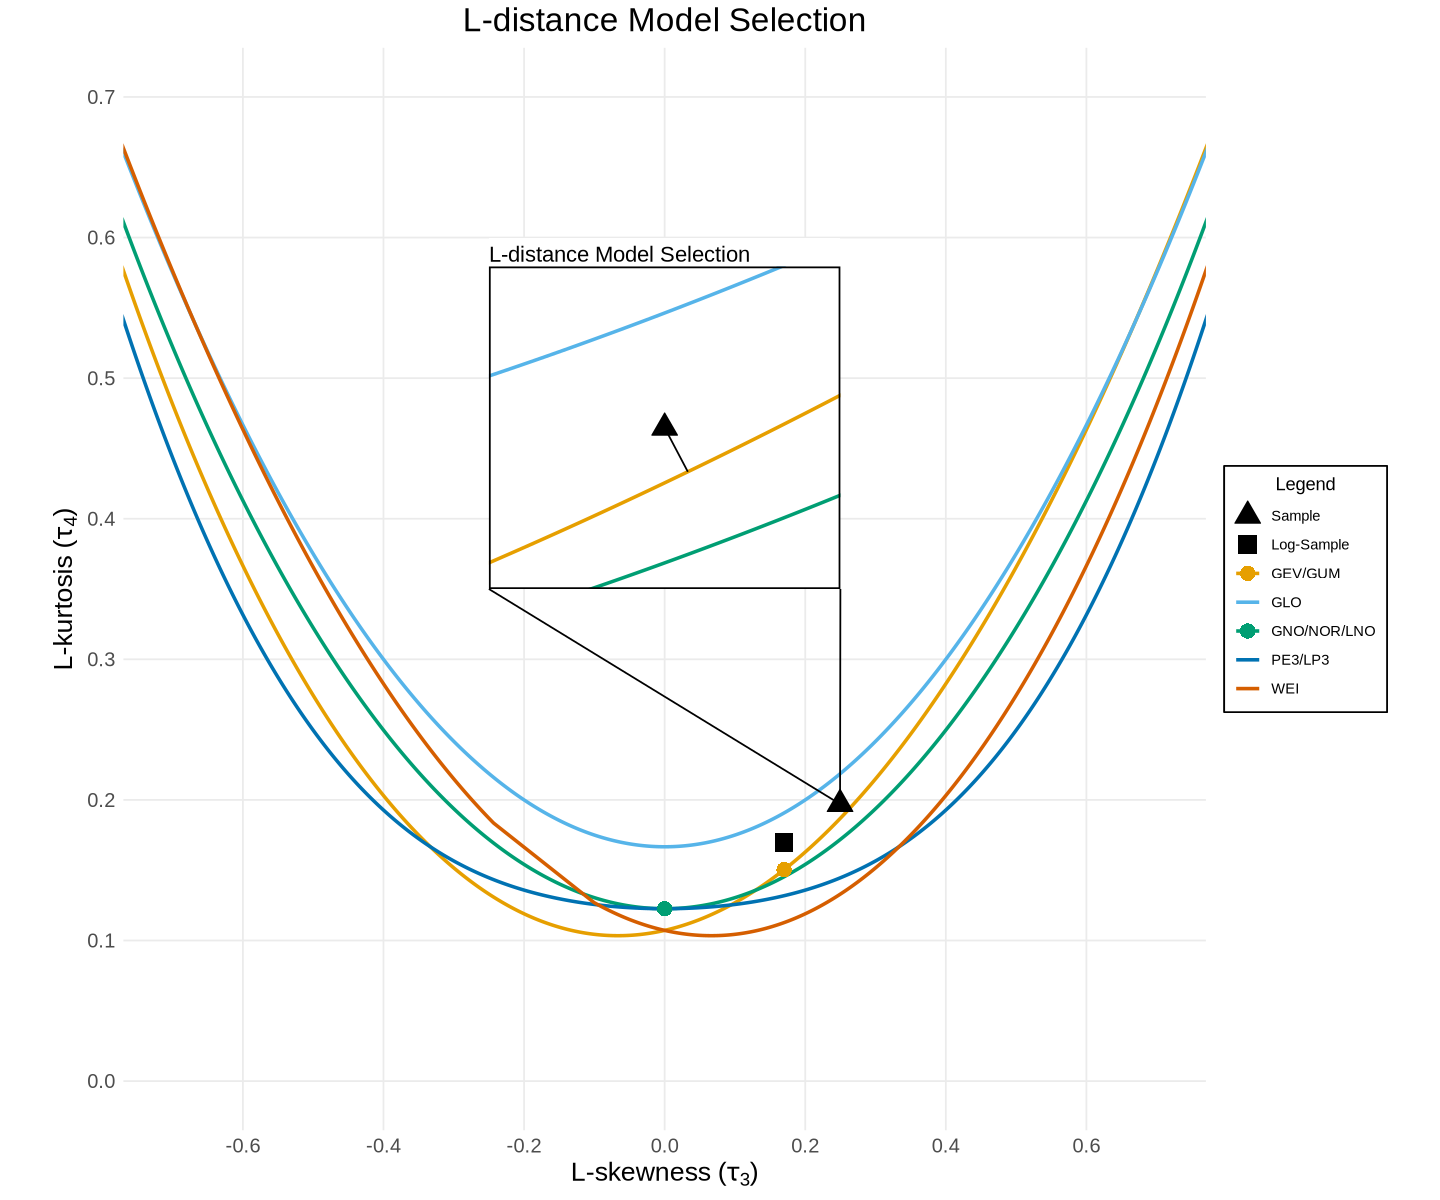

In [2]:
selection <- select_ldistance(df$max)

print(selection$recommendation)

plot_lmom_diagram(selection)

In this case, `select_ldistance` recommended the generalized extreme value (GEV) distribution.
For information about the other distributions, see the `selection$metrics` item.
On the L-moments diagram, the GEV distribution (indicated by the yellow line), is the closest to the sample L-moments (indicated by the black triangle).
You can find more information about the probability distributions supported by the framework [here](https://rileywheadon.github.io/ffa-docs/distributions/).



## Parameter Estimation

After selecting a distribution, the next step is parameter estimation.
The `ffaframework` package provides two methods for parameter estimation:

- `fit_lmom_*`: L-moments 
- `fit_maximum_likelihood`: Maximum likelihood & generalized maximum likelihood

See [here](https://rileywheadon.github.io/ffa-docs/parameter-estimation/) for more information.

This vignette will use L-moments parameter estimation.
Each distribution has its own method for L-moment parameter estimation with the prefix `fit_lmom`. 
The `fit_lmom_gev` method estimates the parameters of the generalized extreme value (GEV) distribution, the recommended distribution from the previous step.

In [3]:
params <- fit_lmom_gev(df$max)

print(params)

[1] 1600.219872  616.666030    0.120747


## Uncertainty Quantification

Given a fitted probability distribution it is easy to estimate the return levels. 
However, point estimates alone are insufficient; confidence intervals should also be reported.
The `uncertainty_bootstrap` function performs uncertainty quantification using the sample bootstrap method. It requires three arguments:

- `data`: A vector of annual maximum streamflow observations.
- `model`: A three-letter code for a probability distribution (ex. `"GEV"`)
- `method`: A parameter estimation method. Must be `"L-moments"`, `"MLE"`, or `"GMLE"`.

By default, return levels are computed 2-, 5-, 10-, 20-, 50-, and 100- year return periods. 
The `plot_uncertainty` method generates a plot of the results.

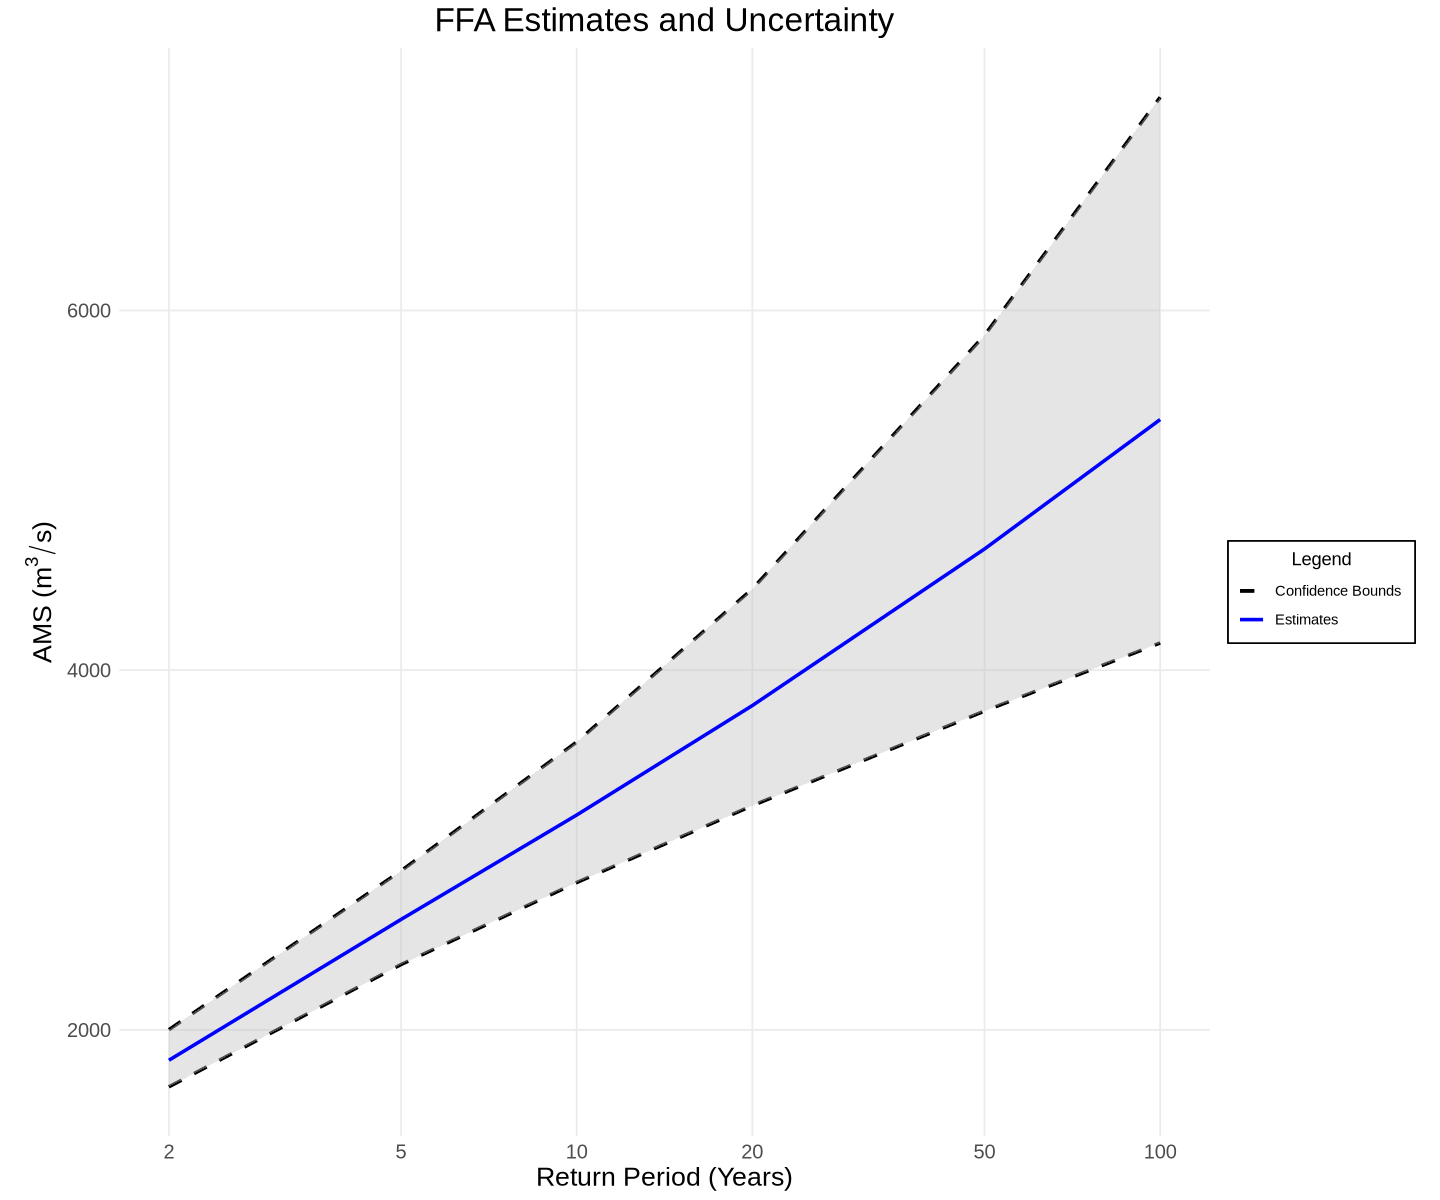

In [4]:
uncertainty <- uncertainty_bootstrap(df$max, "GEV", "L-moments")

plot_uncertainty(uncertainty)

## Model Assessment

Model performance is assessed using `model_diagnostics`, which reports a collection of assessment statistics about the flood frequency analysis.
Many of these assessment statistics are determined by comparing the predictions of the parametric model with the empirical plotting positions (see [here](https://rileywheadon.github.io/ffa-docs/model-assessment/) for more information).

The `plot_model_diagnostics` generates a visual comparison of the empirical plotting positions (the "Observed Quantiles") and the predictions of the parametric model (the "Model Quantiles"). 
The black line represents a perfect 1:1 correspondence between the model and the data.

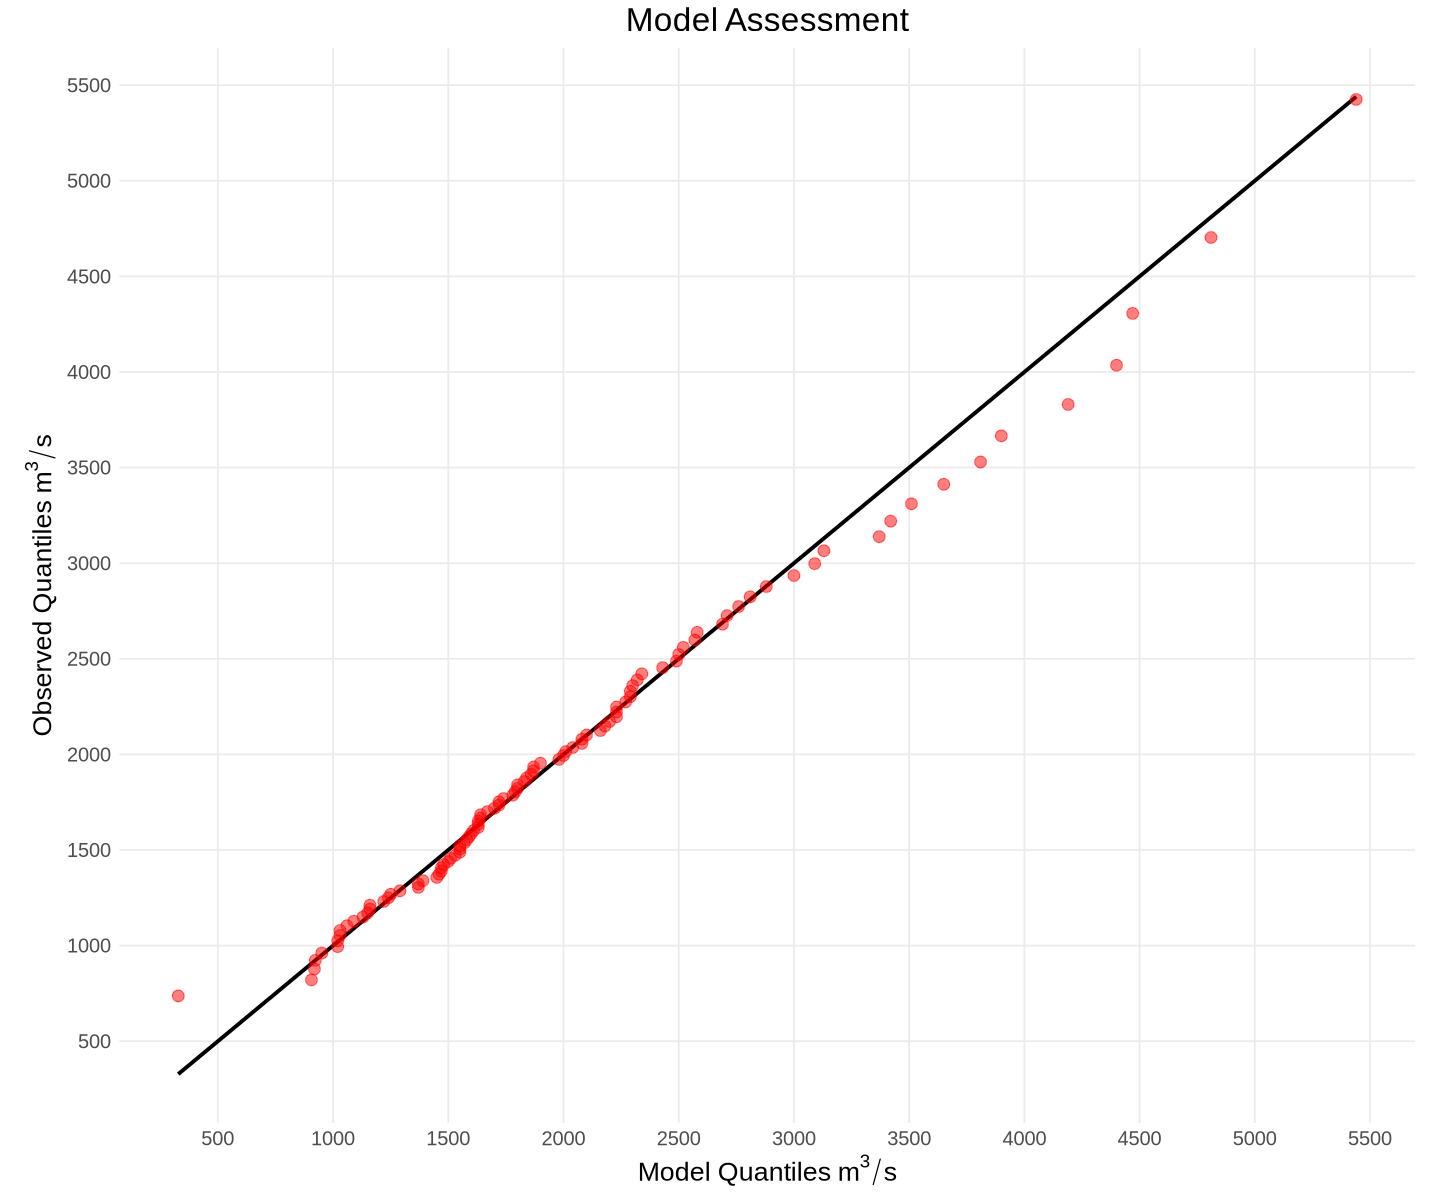

In [5]:
diagnostics <- model_diagnostics(df$max, "GEV", params, uncertainty)

plot_model_diagnostics(diagnostics)

The plot shows that the parametric model is closely aligned with the empirical plotting positions, except for a small negative bias between $3000\text{m}^3/\text{s}$ and $4500\text{m}^3/\text{s}$.



## Conclusion

This vignette demonstrated a complete stationary FFA workflow using the `ffaframework` package.
By selecting a distribution, estimating parameters via L-moments, quantifying uncertainty, and assessing model fit, users can generate reproducible and statistically rigorous estimates of return levels for AMS data.